In [2]:
import jax

jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools

In [3]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [108]:
import matplotlib.pyplot as plt

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

import pandas as pd
from matplotlib.gridspec import GridSpec

In [5]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tens

## Computational efficiency standard implementation and AD derived implementation for stress and tangent modulii

Here we test hoe much computation time does it take to compute stress and tangent moduluu from a standard implementation and a AD derived implementation. 


## single pixel efficieny test
We test it for a single pixel point. 

Defining material parameters for the single pixel point. 

In [6]:
ndim = 2

In [7]:
E = 1
nu = 0.3
λ0 = nu * E / ((1 + nu) * (1 - 2 * nu))
μ0 = E / (2 * (1 + nu))
K = λ0 + 2 * μ0 / 3

Defining the stress and tangent modulli using analytical expression. 

In [8]:
# identity tensor (single tensor)
I = np.eye(ndim)

# identity tensors (grid)
I4 = np.einsum("il,jk", I, I)  # 4th order Identity tensor
I4rt = np.einsum("ik,jl", I, I)
I4s = (I4 + I4rt) / 2.0

II = np.einsum("ij, kl->ijkl", I, I)


C4 = K * II + 2.0 * μ0 * (I4s - 1.0 / 3.0 * II)


def st_venant_stress(F):
    S = np.einsum("ijkl, kl->ij", C4, 0.5 * (np.einsum("ij, jk-> ik", F.T, F) - I))
    P = np.einsum("ij, jk->ik", F, S)
    return P


def st_venant_tangent_modulii(F):

    S = np.einsum("ijkl, kl->ij", C4, 0.5 * (np.einsum("ij, jk-> ik", F.T, F) - I))

    K4 = np.einsum("ij, jkmn->ikmn", S, I4) + np.einsum(
        "ijkl,lkmn->ijmn",
        np.einsum(
            "ijkl,lkmn->ijmn",
            I4rt,
            np.einsum("ijkl,lm->ijkm", np.einsum("ij,jkmn->ikmn", F, C4), F.T),
        ),
        I4rt,
    )
    return K4

Deriving stress and tangent modulii using AD from strain energy density. 

In [56]:
@jax.jit
def green_lagrange_strain(F):
    I = jnp.eye(ndim)
    return 0.5 * (jnp.einsum("ij, jk-> ik", F.T, F) - I)


@jax.jit
def strain_energy(F):
    E = green_lagrange_strain(F)
    E = 0.5 * (E + E.T)
    energy = 0.5 * jnp.multiply(λ0, jnp.einsum("ii->", E) ** 2) + jnp.multiply(
        μ0, jnp.einsum("ii->", jnp.einsum("ij, jk->ik", E, E))
    )
    return energy.sum()


piola_kirchhoff_fwd = jax.jit(jax.jacfwd(strain_energy))
piola_kirchhoff_rev = jax.jit(jax.jacrev(strain_energy))

tangent_modulii_fwd = jax.jit(jax.jacfwd(piola_kirchhoff_fwd))
tangent_modulii_rev = jax.jit(jax.jacrev(piola_kirchhoff_rev))

Defining a pseudo deformation gradient at which stress and tangent modulii are to be computed 

In [46]:
F = np.array([[1.0, 0.1], [1.0, 1.0]])

In [11]:
st_venant_stress(F)

array([[0.71826923, 0.45259615],
       [1.09903846, 0.71826923]])

In [12]:
%%timeit
st_venant_stress(F)

7.08 μs ± 23 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
%%timeit
st_venant_tangent_modulii(F)

18 μs ± 382 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
st_venant_tangent_modulii(F)

(2, 2, 2, 2)

In [15]:
%%timeit
piola_kirchhoff_fwd(F).block_until_ready()

The slowest run took 5.50 times longer than the fastest. This could mean that an intermediate result is being cached.
10.7 μs ± 9.17 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
tangent_modulii_fwd(F).block_until_ready()

5.82 μs ± 30.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
tangent_modulii_fwd(F)

Array([[[[2.02596154, 0.51923077],
         [1.38461538, 0.61538462]],

        [[0.51923077, 0.69326923],
         [0.44230769, 0.51923077]]],


       [[[1.38461538, 0.44230769],
         [2.40673077, 1.38461538]],

        [[0.61538462, 0.51923077],
         [1.38461538, 2.02596154]]]], dtype=float64)

## using analytical 

In [102]:
results = {}

In [67]:
def tangent_modulii_ana(F):

    S = jnp.einsum("ijkl, kl->ij", C4, 0.5 * (jnp.einsum("ij, jk-> ik", F.T, F) - I))

    K4 = jnp.einsum("ij, jkmn->ikmn", S, I4) + jnp.einsum(
        "ijkl,lkmn->ijmn",
        jnp.einsum(
            "ijkl,lkmn->ijmn",
            I4rt,
            jnp.einsum("ijkl,lm->ijkm", jnp.einsum("ij,jkmn->ikmn", F, C4), F.T),
        ),
        I4rt,
    )
    return K4

In [111]:
@jax.jit
def increment_stress_ana(F):
    K4 = tangent_modulii_ana(F)
    return jnp.einsum("ijkl, kl->ij", K4, jnp.ones_like(F))

In [112]:
%%timeit
increment_stress_ana(F).block_until_ready()

6.35 μs ± 217 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [113]:
increment_stress_ana(F)

Array([[4.54519231, 5.61826923],
       [2.17403846, 4.54519231]], dtype=float64)

In [395]:
results['ana'] = %timeit -n100 -r100 -o increment_stress_ana(F).block_until_ready()

The slowest run took 30.33 times longer than the fastest. This could mean that an intermediate result is being cached.
6.4 μs ± 13.8 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)


## using `JVP` product

In [18]:
%%timeit
jax.jvp(piola_kirchhoff_fwd, (F,), (jnp.ones_like(F),))

228 μs ± 718 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
jax.jvp(piola_kirchhoff_fwd, (F,), (jnp.ones_like(F),))

(Array([[0.71826923, 0.45259615],
        [1.09903846, 0.71826923]], dtype=float64),
 Array([[4.54519231, 2.17403846],
        [5.61826923, 4.54519231]], dtype=float64))

In [115]:
results['jvp'] = %timeit -n100 -r100 -o jax.jvp(piola_kirchhoff_fwd, (F,), (jnp.ones_like(F),))

245 μs ± 20.2 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)


## using `linearize` mode

In [79]:
%%timeit
_, f_vjp = jax.linearize(piola_kirchhoff_fwd, F )

626 μs ± 2.56 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [93]:
_, f_vjp = jax.linearize(piola_kirchhoff_fwd, F )

In [81]:
%%timeit
f_vjp(jnp.ones_like(F))

158 μs ± 5.57 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [116]:
results['linearize'] = %timeit -n100 -r100 -o f_vjp(F).block_until_ready()

89.8 μs ± 10.2 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)


## using forward mode to compute tangent and then increment stresses

In [89]:
@jax.jit
def increment_stress_fwd(F):
    K4 = tangent_modulii_fwd(F)
    return jnp.einsum("ijkl, kl->ij", K4, jnp.ones_like(F))

In [77]:
%%timeit
increment_stress_fwd(F).block_until_ready()

5.71 μs ± 21.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [90]:
increment_stress_fwd(F)

Array([[4.54519231, 2.17403846],
       [5.61826923, 4.54519231]], dtype=float64)

In [117]:
results['fwd'] = %timeit -n100 -r100 -o increment_stress_fwd(F).block_until_ready()

The slowest run took 5.85 times longer than the fastest. This could mean that an intermediate result is being cached.
6.71 μs ± 3.09 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)


## using reverse mode to compute tangent and then increment stresses

In [52]:
@jax.jit
def increment_stress_rev(F):
    K4 = tangent_modulii_rev(F)
    return jnp.einsum("ijkl, kl->ij", K4, jnp.ones_like(F))

In [54]:
%%timeit
increment_stress_rev(F).block_until_ready()

6.21 μs ± 57.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [55]:
increment_stress_rev(F)

Array([[4.54519231, 2.17403846],
       [5.61826923, 4.54519231]], dtype=float64)

In [118]:
results['rev'] = %timeit -n100 -r100 -o increment_stress_rev(F).block_until_ready()

The slowest run took 4.58 times longer than the fastest. This could mean that an intermediate result is being cached.
7.28 μs ± 2.77 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [119]:
results

{'ana': <TimeitResult : 6.13 μs ± 3.21 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)>,
 'jvp': <TimeitResult : 245 μs ± 20.2 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)>,
 'linearize': <TimeitResult : 89.8 μs ± 10.2 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)>,
 'fwd': <TimeitResult : 6.71 μs ± 3.09 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)>,
 'rev': <TimeitResult : 7.28 μs ± 2.77 μs per loop (mean ± std. dev. of 100 runs, 100 loops each)>}

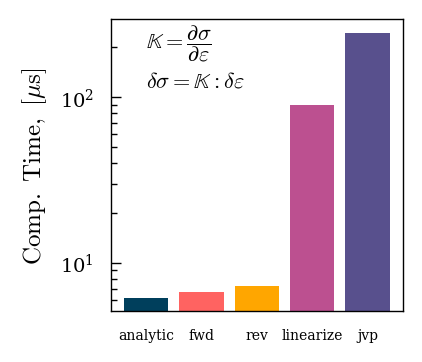

In [161]:
fig = plt.figure(
    figsize=set_size(width="two-column", fraction=0.9, height_ratio=0.33),
    constrained_layout=True,
    dpi=200,
)
gs1 = GridSpec(1, 2, figure=fig, width_ratios=[1, 3])

ax = fig.add_subplot(gs1[0, 0])

ax.bar('analytic', results['ana'].average*1e6, color='#003f5c', width=0.8)
ax.bar('fwd', results['fwd'].average*1e6, color='#ff6361',  width=0.8)
ax.bar('rev', results['rev'].average*1e6, color='#ffa600',  width=0.8)
ax.bar('linearize', results['linearize'].average*1e6, color='#bc5090',  width=0.8)
ax.bar('jvp', results['jvp'].average*1e6, color='#58508d',  width=0.8)

ax.text(0, 200, r"$\mathbb{K}=\dfrac{\partial \sigma}{\partial \varepsilon}$"
        , fontsize=8, color="k",)
ax.text(0, 115, r"$\delta \sigma= \mathbb{K}:\delta\varepsilon$"
        , fontsize=8, color="k",)
ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis='x', which='major', labelsize=5)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{Comp.~Time,~[\mu s]}$')

ax.set_aspect(1/ax.get_data_ratio())

plt.show()

In [278]:
results_pixels = {}

## Multiple pixel efficieny test

In [323]:
ndim = 2
N = 255

In [324]:
λ0grid = jnp.ones((N, N))*λ0
    
μ0grid = jnp.ones((N, N))*μ0

Kgrid= λ0grid + 2 * μ0grid / 3

In [325]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I_grid = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor

# identity tensors (grid)
I    = jnp.einsum('ij,xy'          ,                  i   ,jnp.ones([N,N]))  # 2nd order Identity tensor
I4   = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('il,jk',i,i),jnp.ones([N,N])) # 4th order Identity tensor
I4rt = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('ik,jl',i,i),jnp.ones([N,N]))
I4s  = (I4+I4rt)/2.

II   = tens.dyad22(I,I)

In [326]:
@jax.jit
def green_lagrange_strain_grid(F):
    return 0.5 * (tens.dot22(tens.trans2(F), F) - I_grid)


@jax.jit
def strain_energy_grid(F):
    E = green_lagrange_strain_grid(F)
    E = 0.5 * (E + tens.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tens.trace2(E) ** 2) + jnp.multiply(
        μ0, tens.trace2(tens.dot22(E, E))
    )
    return energy.sum()

@jax.jit
def piola_kirchhoff_grid_ana(F):
    C4 = Kgrid*II+2.*μ0grid*(I4s-1./3.*II)
    S  = tens.ddot42(C4,.5*(tens.dot22(tens.trans2(F),F)-I))
    P  = tens.dot22(F,S)
    return P

@jax.jit
def tangent_modulii_grid_ana(F):
    C4 = Kgrid*II+2.*μ0grid*(I4s-1./3.*II)
    S  = tens.ddot42(C4,.5*(tens.dot22(tens.trans2(F),F)-I))
    P  = tens.dot22(F,S)
    K4 = tens.dot24(S,I4)+tens.ddot44(tens.ddot44(I4rt,tens.dot42(tens.dot24(F,C4),tens.trans2(F))),I4rt)
    return K4


piola_kirchhoff_grid_rev = jax.jit(jax.jacrev(strain_energy_grid))
piola_kirchhoff_grid_fwd = jax.jit(jax.jacfwd(strain_energy_grid))

In [327]:
eps = jnp.ones([ndim, ndim, N, N])
eps = eps.at[0, 0].set(1.)
eps = eps.at[0, 1].set(0.1)
eps = eps.at[1, 0].set(1.)
eps = eps.at[1, 1].set(1.)

In [284]:
%%timeit
piola_kirchhoff_grid_ana(eps).block_until_ready()

148 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [38]:
%%timeit
piola_kirchhoff_grid_rev(eps).block_until_ready()

2.92 ms ± 12.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
piola_kirchhoff_grid_fwd(eps).block_until_ready()

In [28]:
batched_piola_kirchoff = jax.jit(jax.vmap(piola_kirchhoff_rev, in_axes=(0)))

In [29]:
%%timeit
eps_re = jnp.array([eps[:, :, i, j] for i, j in itertools.product(range(N), repeat=2)])
batched_piola_kirchoff(eps_re).block_until_ready()

4.75 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
eps_re = jnp.array([eps[:, :, i, j] for i, j in itertools.product(range(N), repeat=2)])

4.77 s ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
eps_re = jnp.array([eps[:, :, i, j] for i, j in itertools.product(range(N), repeat=2)])

In [32]:
%%timeit
batched_piola_kirchoff(eps_re).block_until_ready()

2.56 ms ± 21.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit
eps_re = jnp.transpose(eps, (2, 3, 0, 1)).reshape(N*N, *eps.shape[:2])

142 μs ± 936 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [34]:
eps_re2 = jnp.transpose(eps, (2, 3, 0, 1)).reshape(N*N, *eps.shape[:2])

In [39]:
%%timeit
eps_re = jnp.transpose(eps, (2, 3, 0, 1)).reshape(N*N, *eps.shape[:2])
batched_piola_kirchoff(eps_re).block_until_ready()

2.69 ms ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%%timeit
batched_piola_kirchoff(eps_re2).block_until_ready()

2.54 ms ± 13.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## using analytic for incremental stresses

In [328]:
results_pixels[N] = {}

In [329]:
@jax.jit
def increment_stress_grid_ana(F, dF):
    K4 = tangent_modulii_grid_ana(F)
    return tens.trans2(tens.ddot42(K4, tens.trans2(dF.reshape(ndim,ndim,N,N)) ))

In [330]:
results_pixels[N]['analytic'] = %timeit -n50 -r10 -o increment_stress_grid_ana(eps, eps)

26.3 ms ± 3.22 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)


In [331]:
@jax.jit
def increment_stress_grid_ana2(K4, dF):
    return tens.trans2(tens.ddot42(K4, tens.trans2(dF.reshape(ndim,ndim,N,N)) ))

In [332]:
K4 = tangent_modulii_grid_ana(eps)

In [350]:
results_pixels[N]['analytic2'] = %timeit -n50 -r10 -o increment_stress_grid_ana2(K4, eps)

1.8 ms ± 111 μs per loop (mean ± std. dev. of 10 runs, 50 loops each)


## using `JVP` for incremental stresses

In [334]:
results_pixels[N]['jvp'] = %timeit -n50 -r10 -o jax.jvp(piola_kirchhoff_grid_rev, (eps,), (eps,))

12.9 ms ± 1.38 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)


## using `linearize` for incremental stresses

In [335]:
_, f_vjp = jax.linearize(piola_kirchhoff_grid_rev, eps)

In [336]:
results_pixels[N]['linearize2'] = %timeit -n50 -r10 -o f_vjp(eps)

8.98 ms ± 629 μs per loop (mean ± std. dev. of 10 runs, 50 loops each)


In [337]:
@jax.jit
def increment_stress_linearize(F, dF):
    _, f_vjp = jax.linearize(piola_kirchhoff_grid_rev, F)
    return f_vjp(dF)

In [338]:
results_pixels[N]['linearize'] = %timeit -n50 -r10 -o increment_stress_linearize(eps, eps).block_until_ready()

11.1 ms ± 1.14 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)


## using `fwd` mode to compute tangent modulii and then incremental stresses

In [339]:
batched_tangent_modulii_fwd = jax.jit(jax.vmap(increment_stress_fwd, in_axes=(0)))

In [340]:
eps_re = jnp.transpose(eps, (2, 3, 0, 1)).reshape(N*N, *eps.shape[:2])

In [341]:
results_pixels[N]['fwd'] = %timeit -n50 -r10 -o batched_tangent_modulii_fwd(eps_re)

40.4 ms ± 737 μs per loop (mean ± std. dev. of 10 runs, 50 loops each)


## using `rev` mode

In [342]:
batched_tangent_modulii_rev = jax.jit(jax.vmap(increment_stress_rev, in_axes=(0)))

In [343]:
results_pixels[N]['rev'] = %timeit -n50 -r10 -o batched_tangent_modulii_rev(eps_re)

64.7 ms ± 1.21 ms per loop (mean ± std. dev. of 10 runs, 50 loops each)


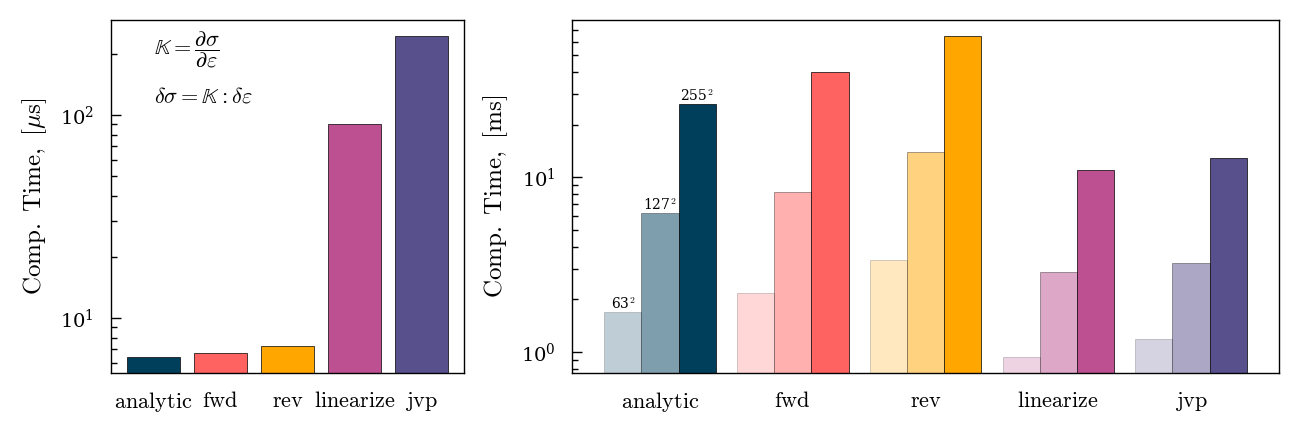

In [406]:
fig = plt.figure(
    figsize=set_size(width="two-column", fraction=0.9, height_ratio=0.33),
    constrained_layout=True,
    dpi=200,
)
gs1 = GridSpec(1, 2, figure=fig, width_ratios=[0.5, 1])

method = [r'$\mathrm{analytic}$', r'$\mathrm{fwd}$', r'$\mathrm{rev}$', r'$\mathrm{linearize}$', r'$\mathrm{jvp}$']

ax = fig.add_subplot(gs1[0, 0])

ax.bar(1, results['ana'].average*1e6, color='#003f5c', width=0.8, edgecolor='k', linewidth=0.25)
ax.bar(2, results['fwd'].average*1e6, color='#ff6361',  width=0.8, edgecolor='k', linewidth=0.25)
ax.bar(3, results['rev'].average*1e6, color='#ffa600',  width=0.8, edgecolor='k', linewidth=0.25)
ax.bar(4, results['linearize'].average*1e6, color='#bc5090',  width=0.8, edgecolor='k', linewidth=0.25)
ax.bar(5, results['jvp'].average*1e6, color='#58508d',  width=0.8, edgecolor='k', linewidth=0.25)

ax.set_xticks([1, 2, 3, 4, 5], method);


ax.text(1, 200, r"$\mathbb{K}=\dfrac{\partial \sigma}{\partial \varepsilon}$"
        , fontsize=8, color="k",)
ax.text(1, 115, r"$\delta \sigma= \mathbb{K}:\delta\varepsilon$"
        , fontsize=8, color="k",)
ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{Comp.~Time,~[\mu s]}$')

ax.set_aspect(1/ax.get_data_ratio())

ax = fig.add_subplot(gs1[0, 1])

values = [63, 127, 255]
n = len(values)                # Number of bars to plot
w = .28                       # With of each column
x = np.arange(0, len(method))   # Center position of group on x axis

alphas = [0.25, 0.5, 1]

for i, value in enumerate(values):
    position = x + (w*(1-n)/2) + i*w
    
    bar1 = ax.bar(position[0], results_pixels[value]['analytic'].average*1e3, color='#003f5c', width=w, alpha=alphas[i], 
                  edgecolor='k', linewidth=0.25)
    bar2 = ax.bar(position[1], results_pixels[value]['fwd'].average*1e3, color='#ff6361',  width=w, alpha=alphas[i], 
                 edgecolor='k', linewidth=0.25)
    bar3 = ax.bar(position[2], results_pixels[value]['rev'].average*1e3, color='#ffa600',  width=w, alpha=alphas[i], 
                 edgecolor='k', linewidth=0.25)
    bar4 = ax.bar(position[3], results_pixels[value]['linearize'].average*1e3, color='#bc5090',  width=w, alpha=alphas[i], 
                 edgecolor='k', linewidth=0.25)
    bar5 = ax.bar(position[4], results_pixels[value]['jvp'].average*1e3, color='#58508d',  width=w, alpha=alphas[i], 
                 edgecolor='k', linewidth=0.25)

    # Add counts above the two bar graphs
    for rect in bar1:# + bar2 + bar3 + bar4 + bar5:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{value:.0f}$^2$', ha='center', va='bottom', fontsize=5)


ax.set_xticks(x, method);

ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis='x', which='major', labelsize=8)

ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{Comp.~Time,~[m s]}$')
ax.set_aspect(0.5/ax.get_data_ratio())

plt.savefig('../notebooks/figs/paper_method_efficiency.svg')
plt.show()